In [ ]:
pip install pyserial


Starting data collection...
111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111

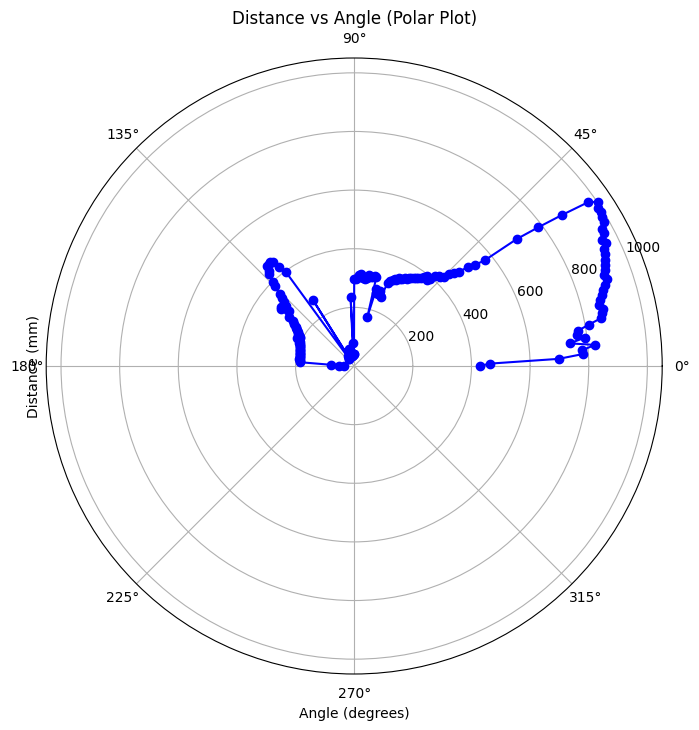

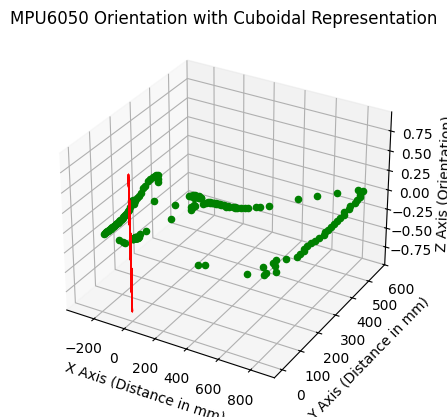

In [1]:
import serial
import time
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Configure the serial port (adjust 'COM3' and baud rate as needed)
ser = serial.Serial('COM9', 9600, timeout=1)
time.sleep(2)  # Wait for the serial connection to initialize

# Initialize lists to hold data
angles = []
distances = []
accel_x = []
accel_y = []
accel_z = []
gyro_x = []
gyro_y = []
gyro_z = []

def parse_value(line, label):
    """Extracts and returns the integer value from a line based on the label."""
    try:
        value_str = line.split(label + ":")[1].strip()
        return int(value_str.split()[0])  # Take only the first part in case of extra text
    except (ValueError, IndexError) as e:
        print(f"Error parsing {label}: {line} - {e}")
        return None

try:
    print("Starting data collection...")
    while True:
        line = ser.readline().decode('utf-8').strip()  # Read the line from Arduino
        print(line)  # Debug statement to check the output from Arduino

        if "Angle:" in line:
            angle = parse_value(line, "Angle")
            if angle is not None:
                angles.append(angle)

        if "Distance:" in line:
            distance = parse_value(line, "Distance")
            if distance is not None:
                distances.append(distance)

        if "Accel X:" in line:
            ax = parse_value(line, "Accel X")
            if ax is not None:
                accel_x.append(ax)

        if "Accel Y:" in line:
            ay = parse_value(line, "Accel Y")
            if ay is not None:
                accel_y.append(ay)

        if "Accel Z:" in line:
            az = parse_value(line, "Accel Z")
            if az is not None:
                accel_z.append(az)

        if "Gyro X:" in line:
            gx = parse_value(line, "Gyro X")
            if gx is not None:
                gyro_x.append(gx)

        if "Gyro Y:" in line:
            gy = parse_value(line, "Gyro Y")
            if gy is not None:
                gyro_y.append(gy)

        if "Gyro Z:" in line:
            gz = parse_value(line, "Gyro Z")
            if gz is not None:
                gyro_z.append(gz)

        # Break the loop after collecting data for 180 angles
        if len(angles) >= 180:
            break

finally:
    ser.close()  # Close the serial port

# Check if any data was collected
if not angles or not distances:
    print("No valid data collected.")
else:
    # Polar Plotting of Distance vs Angle
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111, projection='polar')
    angles_rad = np.radians(angles)
    distances_np = np.array(distances)
    ax.plot(angles_rad, distances_np, marker='o', linestyle='-', color='b')
    ax.set_title("Distance vs Angle (Polar Plot)")
    ax.set_xlabel("Angle (degrees)")
    ax.set_ylabel("Distance (mm)")
    plt.show()

    # 3D Visualization of MPU6050 Orientation with a Cuboidal Box
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Define the cuboid dimensions
    cuboid_dimensions = np.array([[0.5, 0.5, 0.5], 
                                   [-0.5, 0.5, 0.5], 
                                   [-0.5, -0.5, 0.5], 
                                   [0.5, -0.5, 0.5], 
                                   [0.5, 0.5, -0.5], 
                                   [-0.5, 0.5, -0.5], 
                                   [-0.5, -0.5, -0.5], 
                                   [0.5, -0.5, -0.5]])
    
    for i in range(len(angles)):
        # Calculate the orientation of the cuboid based on MPU6050 data
        # Assuming ax, ay, az are accelerations (for cuboid orientation)
        # Using mean values for demonstration; you can customize as needed
        roll = np.radians(gyro_x[i])  # Convert to radians
        pitch = np.radians(gyro_y[i])
        yaw = np.radians(gyro_z[i])

        # Rotation matrices for roll, pitch, yaw
        R_x = np.array([[1, 0, 0],
                        [0, np.cos(roll), -np.sin(roll)],
                        [0, np.sin(roll), np.cos(roll)]])

        R_y = np.array([[np.cos(pitch), 0, np.sin(pitch)],
                        [0, 1, 0],
                        [-np.sin(pitch), 0, np.cos(pitch)]])

        R_z = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                        [np.sin(yaw), np.cos(yaw), 0],
                        [0, 0, 1]])

        # Combined rotation matrix
        R = np.dot(R_z, np.dot(R_y, R_x))
        transformed_cuboid = np.dot(cuboid_dimensions, R.T)

        # Translate the cuboid to the position based on distance measurement
        ax.scatter(distances[i] * np.cos(angles_rad[i]), 
                   distances[i] * np.sin(angles_rad[i]), 
                   0, color='g')  # Position of IMU

        # Plot the cuboid
        ax.add_collection3d(Poly3DCollection([transformed_cuboid[[0, 1, 2, 3]], 
                                                transformed_cuboid[[4, 5, 6, 7]], 
                                                transformed_cuboid[[0, 1, 5, 4]], 
                                                transformed_cuboid[[2, 3, 7, 6]], 
                                                transformed_cuboid[[1, 2, 6, 5]], 
                                                transformed_cuboid[[4, 7, 3, 0]]], 
                                               facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

    ax.set_xlabel('X Axis (Distance in mm)')
    ax.set_ylabel('Y Axis (Distance in mm)')
    ax.set_zlabel('Z Axis (Orientation)')
    ax.set_title('MPU6050 Orientation with Cuboidal Representation')
    plt.show()